In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch # entire library
import torch.nn as nn # all neural network moduals, e.g., linear, convolutional, loss function
import torch.optim as optim # optimization function
import torch.nn.functional as F # all functions that do not have parameters, e.g., Relu, Tanh, etc
from torch.utils.data import DataLoader # easier data management
import torchvision.datasets as datasets # standard datasets
from torch.utils.data import Dataset
import torchvision.transforms as transforms # transformations on datasets
from torch.optim.lr_scheduler import ExponentialLR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [3]:
def data_splition(df, id1, id2):
    train = df[:id1,:].astype('float32')
    valid = df[id1:id2,:].astype('float32')
    test  = df[id2:,:].astype('float32')
    return train, valid, test

In [5]:
df_long = pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/New_LSR/211213_根岸LSR平衡還流沸点データ.xlsx",
                     sheet_name='DataBase(432)', header=3, index_col=0, skiprows=range(4,5))
df_short= pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/New_LSR/211213_根岸LSR平衡還流沸点データ.xlsx",
                     sheet_name='DataBase(122)', header=3, index_col=0, skiprows=range(4,5))
df_data = pd.concat([df_long.iloc[:315,:], df_short])

df_date = df_data.pop('Date')

df_target = df_data.pop('bp').values.reshape((-1,1))
data_tr, data_vl, data_te = data_splition(df_data.values, 300, 337)
y_train, y_valid, y_test  = data_splition(df_target, 300, 337)

scaler = StandardScaler()
data_tr = scaler.fit_transform(data_tr)
data_vl = scaler.transform(data_vl)
data_te = scaler.transform(data_te)

Text(0.5, 1.0, 'Data splition when using NNs')

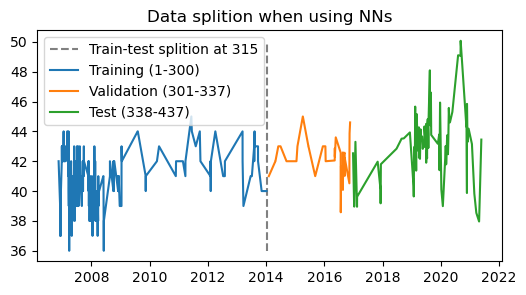

In [8]:
plt.rcParams["figure.figsize"] = (6,3)
plt.vlines(df_date[300], ymin = 36, ymax = 50, ls='--', colors='grey', label='Train-test splition at 315')
plt.plot(df_date[:300], y_train, label='Training (1-300)')
plt.plot(df_date[300:337], y_valid, label='Validation (301-337)')
plt.plot(df_date[337:], y_test, label='Test (338-437)')
plt.legend()
plt.title('Data splition when using NNs')

In [5]:
class NN(nn.Module):
    def __init__(self, n_input): # 45, 10
        super(NN, self).__init__()
        self.fc1 = nn.Linear(n_input, 1)
        # self.fc2 = nn.Linear(n_hidden, 1)

    def forward(self, x):
        x = self.fc1(x)
        # x = F.relu(self.fc1(x))
        # x = self.fc2(x)
        return x


In [8]:
def OneFCLayer(lr, momentum, epoch_num):
    model = NN(n_input=45)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    for epoch in range(epoch_num):
        
        # ----------model training -----------#
        model.train()
        # forward
        predictions = model(torch.from_numpy(data_tr))
        loss = criterion(predictions, torch.from_numpy(y_train))

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

        # ----------model evaluation -----------#
        yvlhat = model(torch.from_numpy(data_vl))
        val_loss = criterion(yvlhat, torch.from_numpy(y_valid))
        if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"{epoch}/{epoch_num} Training loss: {np.sqrt(loss.item()):.4f} Validation loss: {np.sqrt(val_loss.item()):.4f}"
                )
    return model


In [24]:
learning_rate = 0.01
# num_epochs = 1000
momentum = 0.8
epoch_list = [50, 100, 200, 500, 1000, 1500, 2000]
# lr_list = [0.00001, 0.0001, 0.001, 0.003, 0.005]
df_error = pd.DataFrame()
valid_error = pd.DataFrame()
for num_epochs in epoch_list:
    # for num_epochs in epoch_list:
    # for momentum in range(5,10):
    # momentum = momentum/10
    # for learning_rate in range(5):
    # learning_rate = 10**(learning_rate-5)
    model = OneFCLayer(lr=learning_rate,momentum=momentum,epoch_num=num_epochs)
    ytrhat = model(torch.from_numpy(data_tr).requires_grad_()).detach().numpy()
    yvlhat = model(torch.from_numpy(data_vl).requires_grad_()).detach().numpy()
    df_error.at[str(num_epochs), 'train_error'] = np.sqrt(mean_squared_error(ytrhat, y_train))
    df_error.at[str(num_epochs), 'valid_error'] = np.sqrt(mean_squared_error(yvlhat, y_valid))

0 1639.57666015625
0 1648.70751953125
0 1648.96875
100 0.5714165568351746
0 1641.6829833984375
100 0.5724266171455383
200 0.5559950470924377
300 0.5509541034698486
400 0.5484565496444702
0 1644.73388671875
100 0.5665978789329529
200 0.5539541840553284
300 0.5496405959129333
400 0.5473553538322449
500 0.5458910465240479
600 0.5448412895202637
700 0.5440319180488586
800 0.5433740019798279
900 0.5428208708763123
0 1638.7249755859375
100 0.5699271559715271
200 0.5560003519058228
300 0.5508526563644409
400 0.5480974316596985
500 0.5463281273841858
600 0.5450650453567505
700 0.5441029071807861
800 0.5433365106582642
900 0.5427054166793823
1000 0.5421742796897888
1100 0.5417193174362183
1200 0.5413244366645813
1300 0.5409780740737915
1400 0.5406708121299744
0 1657.451171875
100 0.5757968425750732
200 0.5575164556503296
300 0.5516291260719299
400 0.5486985445022583
500 0.5468769073486328
600 0.5455939173698425
700 0.5446193814277649
800 0.5438432097434998
900 0.5432005524635315
1000 0.54265576

In [9]:
OneFCLayer(lr=0.01,momentum=0.8,epoch_num=200)

0/200 Training loss: 40.5579 Validation loss: 40.6684
1/200 Training loss: 39.7417 Validation loss: 38.8102
2/200 Training loss: 38.2936 Validation loss: 36.4836
3/200 Training loss: 36.3730 Validation loss: 33.9394
4/200 Training loss: 34.1125 Validation loss: 31.3495
5/200 Training loss: 31.6225 Validation loss: 28.8048
6/200 Training loss: 28.9965 Validation loss: 26.3310
7/200 Training loss: 26.3147 Validation loss: 23.9141
8/200 Training loss: 23.6441 Validation loss: 21.5294
9/200 Training loss: 21.0373 Validation loss: 19.1631
10/200 Training loss: 18.5333 Validation loss: 16.8250
50/200 Training loss: 0.7845 Validation loss: 1.3637
100/200 Training loss: 0.7559 Validation loss: 1.5775
150/200 Training loss: 0.7489 Validation loss: 1.7055


NN(
  (fc1): Linear(in_features=45, out_features=1, bias=True)
)

In [25]:
df_error

,train_error,valid_error
50,0.778070,1.356189
100,0.757552,1.502384
200,0.745157,1.718261
500,0.739487,1.720666
1000,0.736440,1.722660
1500,0.735117,1.670647
2000,0.734621,1.643026


<AxesSubplot:title={'center':'epoch number'}, ylabel='RMSE'>

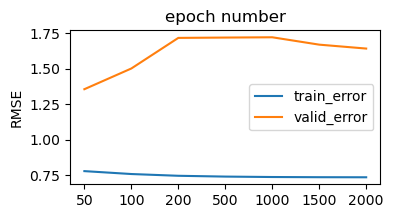

In [26]:
df_error.plot( figsize=(4,2), title='epoch number', ylabel='RMSE')

In [16]:
model = OneFCLayer(lr=0.001,momentum=0.9,epoch_num=2000)
ytrhat = model(torch.from_numpy(data_tr).requires_grad_()).detach().numpy()
yvlhat = model(torch.from_numpy(data_vl).requires_grad_()).detach().numpy()
ytehat = model(torch.from_numpy(data_te).requires_grad_()).detach().numpy()
print(f'Train RMSE: {np.sqrt(mean_squared_error(ytrhat, y_train)):.4f}')
print(f'Valid RMSE: {np.sqrt(mean_squared_error(yvlhat, y_valid)):.4f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(ytehat, y_test)):.4f}')

0/2000 Training loss: 40.7049 Validation loss: 41.9035
1/2000 Training loss: 40.6228 Validation loss: 41.6933
2/2000 Training loss: 40.4671 Validation loss: 41.3956
3/2000 Training loss: 40.2456 Validation loss: 41.0216
4/2000 Training loss: 39.9654 Validation loss: 40.5818
5/2000 Training loss: 39.6329 Validation loss: 40.0861
6/2000 Training loss: 39.2544 Validation loss: 39.5439
7/2000 Training loss: 38.8351 Validation loss: 38.9637
8/2000 Training loss: 38.3802 Validation loss: 38.3532
9/2000 Training loss: 37.8942 Validation loss: 37.7195
10/2000 Training loss: 37.3811 Validation loss: 37.0687
50/2000 Training loss: 15.5564 Validation loss: 15.1381
100/2000 Training loss: 4.2320 Validation loss: 4.1240
150/2000 Training loss: 1.3421 Validation loss: 1.4878
200/2000 Training loss: 0.8278 Validation loss: 1.2158
250/2000 Training loss: 0.7748 Validation loss: 1.2754
300/2000 Training loss: 0.7668 Validation loss: 1.3400
350/2000 Training loss: 0.7629 Validation loss: 1.3954
400/2000

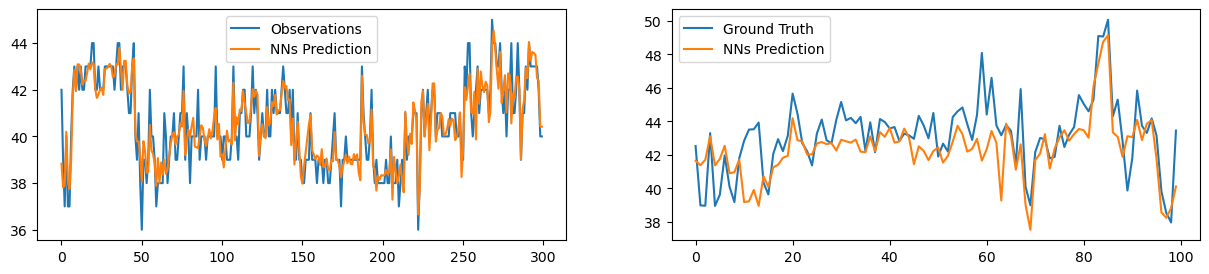

In [21]:
fig, axes = plt.subplots(1,2, figsize=(15,3))


# axes[0].set_title(f'OLS RMSE: {np.sqrt(mean_squared_error(ytrhat_ols, y_train)):.4f}, NNs RMSE: {np.sqrt(mean_squared_error(ytrhat, y_train)):.4f}')
axes[0].plot(y_train, label='Observations')
# axes[0].plot(ytrhat_ols, label='OLS Predictions')
axes[0].plot(ytrhat, label='NNs Prediction')
axes[0].legend()


# axes[1].set_title(f'OLS RMSE: {np.sqrt(mean_squared_error(ytehat_ols, y_test)):.4f}, NNs RMSE: {np.sqrt(mean_squared_error(ytehat, y_test)):.4f}')
axes[1].plot(y_test, label='Ground Truth')
# axes[1].plot(ytehat_ols, label='OLS Predictions')
axes[1].plot(ytehat, label='NNs Prediction')

plt.legend()

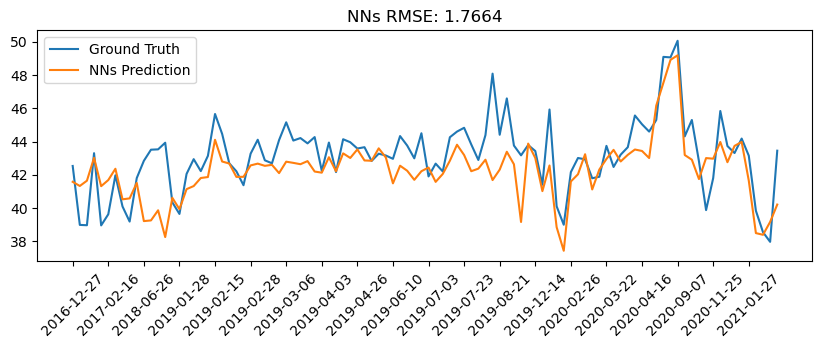

In [17]:
test_date = [df_date.dt.date.iloc[337+5*i] for i in range(20)]

fig, axes = plt.subplots(figsize=(10,3))
ytehat = model(torch.from_numpy(data_te).requires_grad_()).detach().numpy()
axes.set_title(f'NNs RMSE: {np.sqrt(mean_squared_error(ytehat, y_test)):.4f}')
axes.set_xticks(np.arange(20)*5, test_date, rotation='45')
axes.plot(y_test, label='Ground Truth')
axes.plot(ytehat, label='NNs Prediction')
plt.legend()

In [16]:
y_test.shape

(100, 1)

Text(0, 0.5, 'Prediction error')

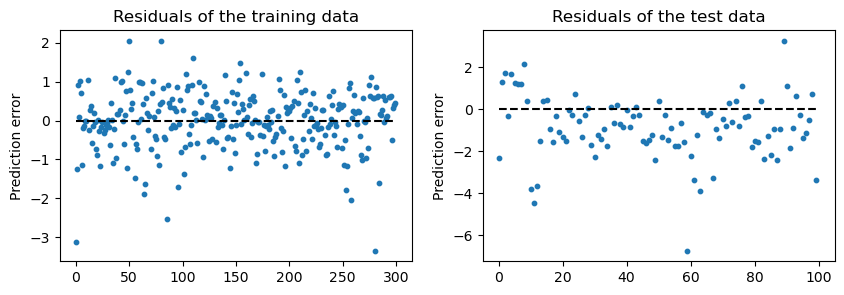

In [212]:
fig, axes = plt.subplots(1,2, figsize=(10,3))
axes[0].scatter(np.arange(len(y_train)), ytrhat-y_train, s=10)
axes[0].hlines(y = 0, xmin = 0, xmax = 300, colors='k', ls = '--')
axes[0].set_title('Residuals of the training data')
axes[0].set_ylabel('Prediction error')
axes[1].scatter(np.arange(len(y_test)), ytehat-y_test, s=10)
axes[1].hlines(y = 0, xmin = 0, xmax = 100, colors='k', ls = '--')
axes[1].set_title('Residuals of the test data')
axes[1].set_ylabel('Prediction error')

In [237]:
params = []
for param in model.parameters():
    params.append(param.detach().numpy())
    # print(param)

Text(0.5, 1.0, 'OLS params with intercept = 40.5433')

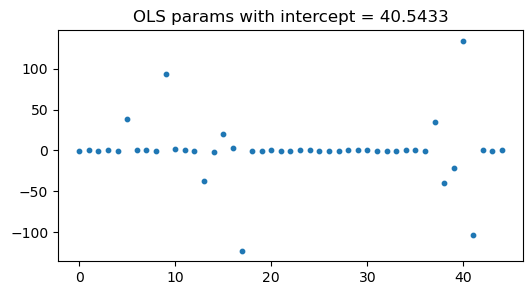

In [240]:
# plt.scatter(np.arange(45), params[0][0], s=10)
plt.scatter(np.arange(45), reg.coef_, s=10)
plt.title('OLS params with intercept = 40.5433')

In [9]:
reg = LinearRegression()
reg.fit(data_tr[:,:], y_train)
ytrhat_ols = reg.predict(data_tr[:,:])
ytehat_ols = reg.predict(data_te[:,:])
print('Train error: %.4f' % np.sqrt(mean_squared_error(ytrhat_ols, y_train)))
print('Test  error: %.4f' % np.sqrt(mean_squared_error(ytehat_ols, y_test)))

Train error: 0.7234
Test  error: 40.9990


In [239]:
reg.intercept_

array([40.54333], dtype=float32)